In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.regularizers import l2


from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report,accuracy_score

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

## Work directory

In [2]:
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

<a id="section-one"></a>
# Data with EDA

In [3]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [4]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
image_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
image_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


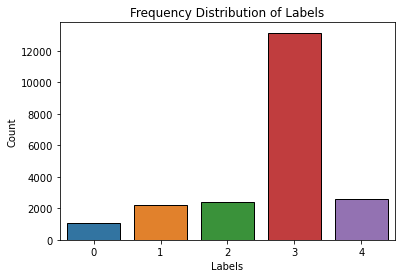

In [6]:
sns.countplot(image_labels.label, edgecolor = 'black')
plt.title('Frequency Distribution of Labels')
sns.set_style("white")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)"

## Photos of dominant class

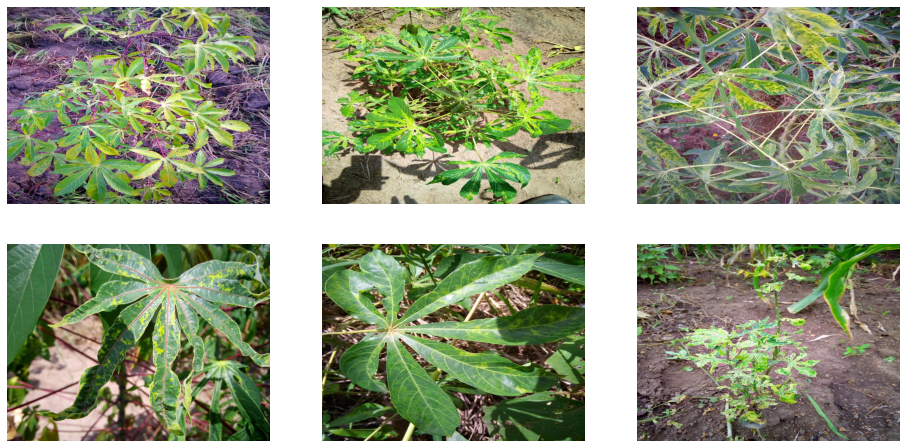

In [7]:
sample = image_labels[image_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## Photos of healthy plants

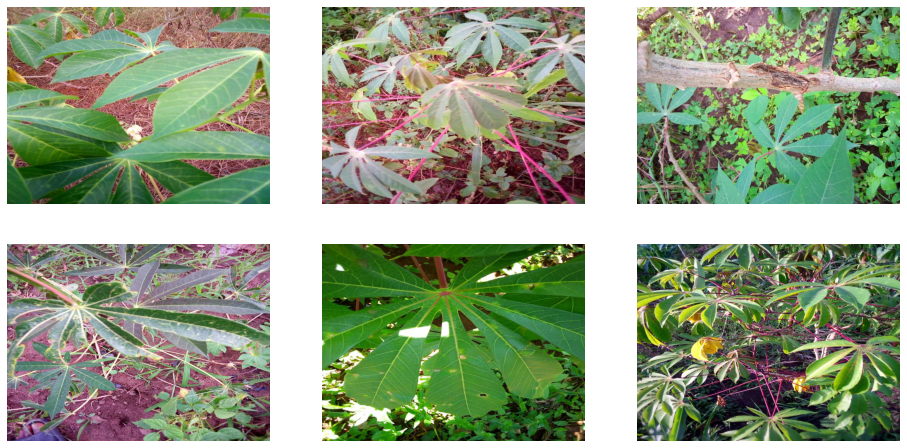

In [8]:
sample = image_labels[image_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

<a id="section-two"></a>
# The baseline level of accuracy

In [9]:
y_pred = [3] * len(image_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, image_labels.label))

The baseline accuracy: 0.615


<a id="section-three"></a>
# Modeling

In [10]:
# The TRAIN/VALID split is performing in the generator directly.

train_labels, test_labels = train_test_split(image_labels, train_size = 0.9, shuffle = True,
                               random_state = 42)

In [11]:
BATCH_SIZE = 12
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 512

In [12]:
train_labels.label = train_labels.label.astype('str')

train_gen = ImageDataGenerator(validation_split = 0.2,
                               preprocessing_function = None,
                               zoom_range = 0.2,
                               cval = 0,
                               rotation_range = 60,
                               horizontal_flip = True,
                               vertical_flip = True,
                               fill_mode = 'nearest',
                               shear_range = 0.15,
                               height_shift_range = 0.15,
                               width_shift_range = 0.15) 

train_generator=train_gen .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 15406 validated image filenames belonging to 5 classes.
Found 3851 validated image filenames belonging to 5 classes.


Found 1 validated image filenames belonging to 1 classes.


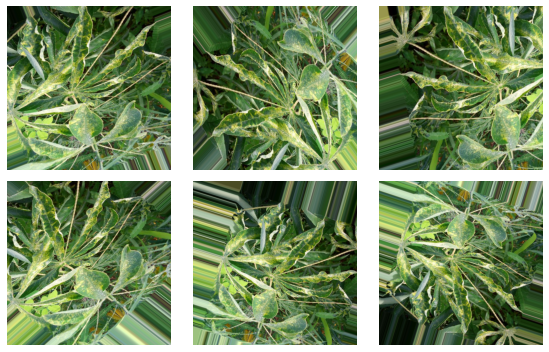

In [13]:
generator = train_gen.flow_from_dataframe(train_labels.iloc[15:16],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(6)]
fig, axes = plt.subplots(2, 3, figsize = (8, 5))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
test_labels.label = test_labels.label.astype('str')

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=os.path.join(WORK_DIR, "train_images"),
    x_col="image_id",
    y_col="label",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',   #category
    shuffle=False  
)

Found 2140 validated image filenames belonging to 5 classes.


In [15]:
def create_model():
    model = models.Sequential([          
            EfficientNetB3(include_top=False, weights='imagenet',
                            input_shape = (TARGET_SIZE, TARGET_SIZE, 3)),
            layers.GlobalAveragePooling2D(),
            layers.Flatten(),
            Dense(256, activation="relu"),
            layers.Dropout(0.3),
            Dense(5, activation='softmax')])

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [16]:
model = create_model()
model.summary()

43941888/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non

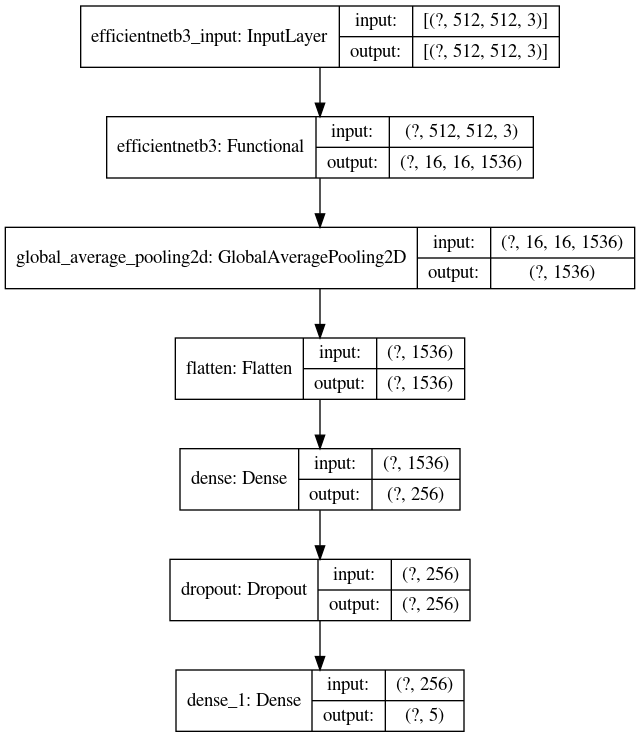

In [17]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
current_balance = train_labels['label'].value_counts(normalize=True)
current_balance

class_weight = {0: (1 - current_balance['0']) / (1 - current_balance.min()),
                1: (1 - current_balance['1']) / (1 - current_balance.min()),
                2: (1 - current_balance['2']) / (1 - current_balance.min()),
                3: (1 - current_balance['3']) / (1 - current_balance.min()),
                4: (1 - current_balance['4']) / (1 - current_balance.min())}

class_weight

{0: 1.0,
 1: 0.9455730164814105,
 2: 0.9370859114055742,
 3: 0.4076548212232383,
 4: 0.9273941849641352}

In [19]:
model_save = ModelCheckpoint('./best_EfficientNetB3_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 4, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    class_weight=class_weight,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
1284/1283 [==============================] - ETA: 0s - loss: 0.5650 - acc: 0.7398
Epoch 00001: val_loss improved from inf to 0.51828, saving model to ./best_EfficientNetB3_model.h5
1284/1283 [==============================] - 1178s 917ms/step - loss: 0.5650 - acc: 0.7398 - val_loss: 0.5183 - val_acc: 0.8325
Epoch 2/20
1284/1283 [==============================] - ETA: 0s - loss: 0.4500 - acc: 0.8026
Epoch 00002: val_loss improved from 0.51828 to 0.47904, saving model to ./best_EfficientNetB3_model.h5
1284/1283 [==============================] - 1107s 862ms/step - loss: 0.4500 - acc: 0.8026 - val_loss: 0.4790 - val_acc: 0.8385
Epoch 3/20
1284/1283 [==============================] - ETA: 0s - loss: 0.4113 - acc: 0.8147
Epoch 00003: val_loss did not improve from 0.47904
1284/1283 [==============================] - 1106s 862ms/step - loss: 0.4113 - acc: 0.8147 - val_loss: 0.7436 - val_acc: 0.7401
Epoch 4/20
1284/1283 [==============================] - ETA: 0s - loss: 0.3925 - acc

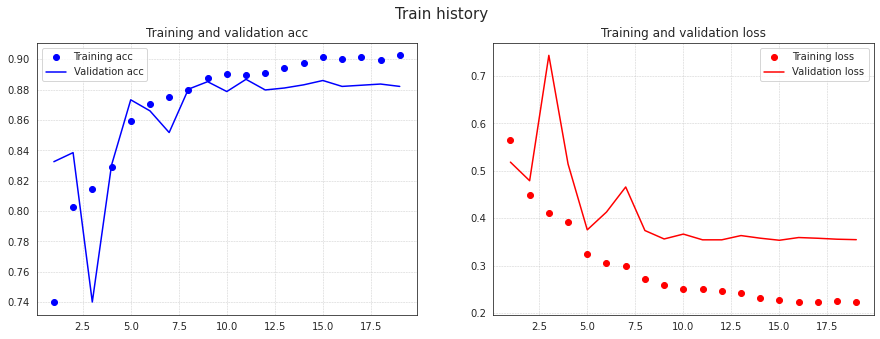

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.show()

In [21]:
model.save('./EfficientNetB3.h5')

In [22]:
test_loss, test_accuracy =model.evaluate(test_generator)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

179/179 [==============================] - 43s 241ms/step - loss: 0.3454 - acc: 0.8855
Test loss: 0.3454192280769348, Test accuracy: 0.8855140209197998


In [23]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = test_generator.classes


accuracy = accuracy_score(true_classes , y_pred_classes)

f1 = f1_score(true_classes, y_pred_classes, average='weighted')

recall = recall_score(true_classes, y_pred_classes, average='weighted')

precision = precision_score(true_classes, y_pred_classes,average="weighted")

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:",precision)
print("F1 Score:", f1)
print(classification_report(true_classes,  y_pred_classes))

Accuracy: 0.8855140186915887
Recall: 0.8855140186915887
Precision: 0.8898670614531323
F1 Score: 0.887188426817961
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        93
           1       0.82      0.82      0.82       201
           2       0.77      0.85      0.81       243
           3       0.97      0.94      0.95      1346
           4       0.73      0.79      0.76       257

    accuracy                           0.89      2140
   macro avg       0.79      0.81      0.80      2140
weighted avg       0.89      0.89      0.89      2140



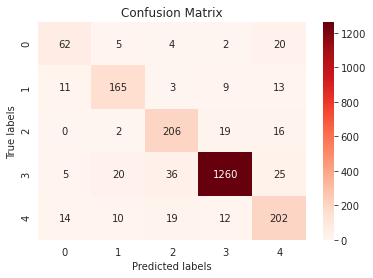

In [24]:
confu_matrix = confusion_matrix(true_classes, y_pred_classes)
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=range(0,5), yticklabels=range(0,5))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()